In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
import re
import datetime
import dateutil
from efunds import EFund

%matplotlib inline

//anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# INDX_raw= {}
# tmp= pd.read_excel('MktIndx.xlsx', sheet_name= 'RU1000TR', skiprows= 5)
# tmp.columns=['Date', 'RU1000TR']
# tmp.set_index(keys= 'Date', inplace=True)
# tmp.index= [x+dateutil.relativedelta.relativedelta(day=31) for x in tmp.index]
# INDX_raw['RU1000TR']= tmp['RU1000TR']

# tmp= pd.read_excel( 'MktIndx.xlsx', sheet_name= 'RU1000VTR', skiprows= 5)
# tmp.columns=['Date', 'RU1000VTR']
# tmp.set_index(keys= 'Date', inplace=True)
# tmp.index= [x+dateutil.relativedelta.relativedelta(day=31) for x in tmp.index]
# INDX_raw['RU1000VTR']= tmp['RU1000VTR']

# tmp= pd.read_excel('MktIndx.xlsx', sheet_name= 'RU1000GTR', skiprows= 5)
# tmp.columns=['Date', 'RU1000GTR']
# tmp.set_index(keys= 'Date', inplace= True)
# tmp.index= [x+dateutil.relativedelta.relativedelta(day=31) for x in tmp.index]
# INDX_raw['RU1000GTR']= tmp['RU1000GTR']

# tmp= pd.read_excel('MktIndx.xlsx', sheet_name= 'SP500TR',skiprows= 5)
# tmp.columns= ['Date', 'SP500TR']
# tmp.set_index(keys= 'Date', inplace=True)
# tmp.index= [x+dateutil.relativedelta.relativedelta(day=31) for x in tmp.index]
# INDX_raw['SP500TR']= tmp['SP500TR']

# pd.concat(INDX_raw.values(), axis=1)
# pickle.dump(INDX_raw, open('INDX_raw.p', 'wb'))



In [3]:
INDX_raw= pickle.load(open('INDX_raw.p','rb'))
INDX_Ret= pd.concat( list({k: (x- x.shift(1))/x.shift(1) for k,x in INDX_raw.items()}.values()), axis=1) 
INDX_Ret['Value_Prem']= INDX_Ret['RU1000VTR']- INDX_Ret['RU1000TR']
INDX_Ret= INDX_Ret.loc[np.logical_and(INDX_Ret.index>= datetime.datetime(1985,1,1), 
                                      INDX_Ret.index<= datetime.datetime(2017, 12,31)), ]

INDX_EFunds= {'RU1000TR': EFund(EProdID='RU1000TR', ret= INDX_Ret['RU1000TR']),
             'RU1000VTR': EFund(EProdID='RU1000VTR', ret= INDX_Ret['RU1000VTR']),
             'RU1000GTR': EFund(EProdID='RU1000GTR', ret= INDX_Ret['RU1000GTR'])}
INDX_Ret['Bull']= INDX_Ret.RU1000TR>=0

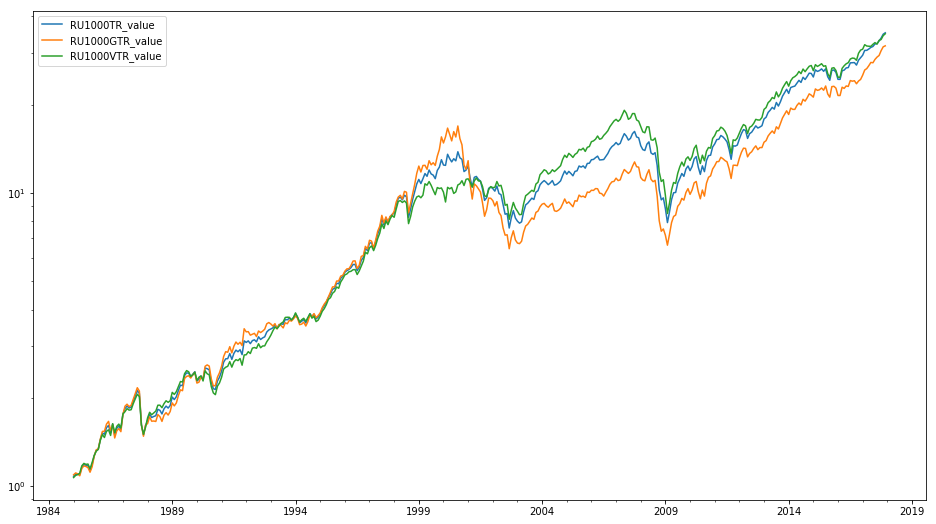

In [4]:

a= pd.concat([x.value for x in INDX_EFunds.values()], axis=1)
a.plot(figsize= (16, 9), logy= True)

In [5]:
# a

Text(0.5,0,'monthly return')

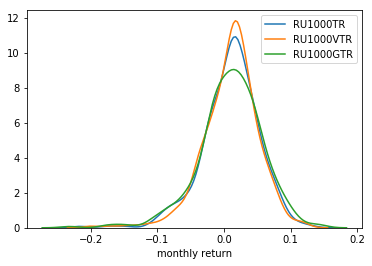

In [6]:
sns.distplot(INDX_Ret['RU1000TR'], label='RU1000TR', hist=False)
sns.distplot(INDX_Ret['RU1000VTR'], label= 'RU1000VTR', hist= False)
sns.distplot(INDX_Ret['RU1000GTR'], label= 'RU1000GTR', hist= False)
plt.legend()
plt.xlabel('monthly return')

In [7]:
INDX_Ret.describe()

RU1000TR   RU1000GTR   RU1000VTR  Value_Prem
count  396.000000  396.000000  396.000000  396.000000
mean     0.009968    0.009957    0.009890   -0.000078
std      0.042998    0.048321    0.041646    0.013728
min     -0.216873   -0.232306   -0.201603   -0.071622
25%     -0.014091   -0.015360   -0.012275   -0.006422
50%      0.013360    0.013204    0.013994   -0.000288
75%      0.038293    0.041541    0.034834    0.006209
max      0.129366    0.143424    0.122014    0.065471

In [8]:
tmp= {}
t= [1e-3, 2e-3, 5e-3,8e-3, 1e-2, 2e-2, 3e-2,  5e-2,8e-2,  10e-2, 12e-2, 15e-2]
for p in t:
    a= {}
    for k,v in INDX_EFunds.items():
        a[k]= v.hVaR(p)[1]
        
    tmp[p]=a
hVaR= pd.DataFrame(tmp).T

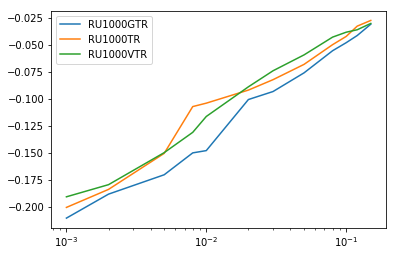

In [9]:
hVaR.plot(logx=True)

In [10]:
INDX_perf= {'DownsideRisk': {k:v.DRisk for k, v in INDX_EFunds.items()},
           'AnnualRet': {k:v.validAnnualRet for k, v in INDX_EFunds.items()},
           'Volatility': {k:v.volatility for k,v in INDX_EFunds.items()},
           'MaxDD': {k:v.MaxDD[1] for k, v in INDX_EFunds.items()},
           'SharpeRatio': {k:v.SharpeRatio() for k,v in INDX_EFunds.items()}}

pd.DataFrame(INDX_perf).T

RU1000GTR  RU1000TR  RU1000VTR
AnnualRet      0.110435  0.113885   0.113623
DownsideRisk   0.111551  0.098653   0.095457
MaxDD         -0.618596 -0.511259  -0.555585
SharpeRatio    0.659748  0.764593   0.787594
Volatility     0.167390  0.148949   0.144266

In [11]:
# Define down turn runs:

Downturns= {0: {'Event': '1987 Black Monday', 'Start': datetime.datetime(1987,9,1), 'End': datetime.datetime(1987,12,1)},
          1: {'Event': '1990 MidEast Oil Crisis', 'Start':datetime.datetime( 1990, 5,1), 'End': datetime.datetime(1990,11,1)},
          2: {'Event': '2000s Market Downturns', 'Start': datetime.datetime( 2000, 2,1), 'End': datetime.datetime(2003, 5,1)},
          3: {'Event': '2008 Financial Crisis', 'Start': datetime.datetime(2007,10,1) ,'End': datetime.datetime(2009, 4,1)},
          4: {'Event': '2015 China Selloff', 'Start': datetime.datetime(2015, 7,1), 'End': datetime.datetime(2016,3,1)}}
dtr_df= pd.DataFrame(Downturns).T


pickle.dump(Downturns, open('Downturns.p', 'wb'))    
dtr_df

End                    Event                Start
0  1987-12-01 00:00:00        1987 Black Monday  1987-09-01 00:00:00
1  1990-11-01 00:00:00  1990 MidEast Oil Crisis  1990-05-01 00:00:00
2  2003-05-01 00:00:00   2000s Market Downturns  2000-02-01 00:00:00
3  2009-04-01 00:00:00    2008 Financial Crisis  2007-10-01 00:00:00
4  2016-03-01 00:00:00       2015 China Selloff  2015-07-01 00:00:00

## Event Analysis 

### 1987 Black Monday

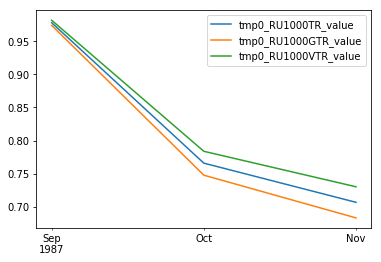

In [13]:
INDX_rets= pd.concat([x.validRet for x in INDX_EFunds.values()], axis= 1)

i=0
start= dtr_df.iloc[i,:]['Start']
end= dtr_df.iloc[i,:]['End']
r1= INDX_rets.loc[np.logical_and(INDX_rets.index> start, INDX_rets.index< end),:]

f1= {}
for k in INDX_rets.columns:
    f1[k]= EFund(ret= r1[k], EProdID='tmp'+str(i)+'_'+ k)
pd.concat([x.value for x in f1.values()], axis= 1).plot()

### 1990 MidEast Oil Crisis 

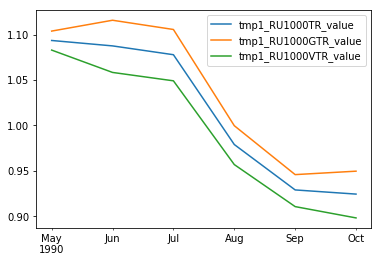

In [14]:
i=1
start= dtr_df.iloc[i,:]['Start']
end= dtr_df.iloc[i,:]['End']
r1= INDX_rets.loc[np.logical_and(INDX_rets.index> start, INDX_rets.index< end),:]

f1= {}
for k in INDX_rets.columns:
    f1[k]= EFund(ret= r1[k], EProdID='tmp'+str(i)+'_'+ k)
pd.concat([x.value for x in f1.values()], axis= 1).plot()

### 2000s Market Downturns

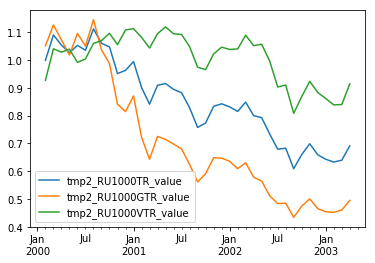

In [15]:


i=2
start= dtr_df.iloc[i,:]['Start']
end= dtr_df.iloc[i,:]['End']
r1= INDX_rets.loc[np.logical_and(INDX_rets.index> start, INDX_rets.index< end),:]

f1= {}
for k in INDX_rets.columns:
    f1[k]= EFund(ret= r1[k], EProdID='tmp'+str(i)+'_'+ k)
pd.concat([x.value for x in f1.values()], axis= 1).plot()

### 2008 Financial Crisis 

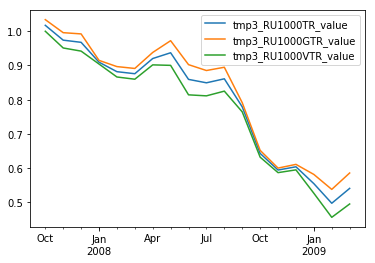

In [16]:
i=3
start= dtr_df.iloc[i,:]['Start']
end= dtr_df.iloc[i,:]['End']
r1= INDX_rets.loc[np.logical_and(INDX_rets.index> start, INDX_rets.index< end),:]

f1= {}
for k in INDX_rets.columns:
    f1[k]= EFund(ret= r1[k], EProdID='tmp'+str(i)+'_'+ k)
pd.concat([x.value for x in f1.values()], axis= 1).plot()

### 2015 China Selloff

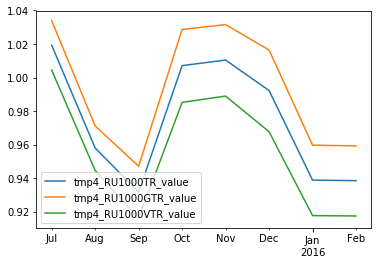

In [17]:
i=4
start= dtr_df.iloc[i,:]['Start']
end= dtr_df.iloc[i,:]['End']
r1= INDX_rets.loc[np.logical_and(INDX_rets.index> start, INDX_rets.index< end),:]

f1= {}
for k in INDX_rets.columns:
    f1[k]= EFund(ret= r1[k], EProdID='tmp'+str(i)+'_'+ k)
pd.concat([x.value for x in f1.values()], axis= 1).plot()

In [23]:
np.percentile(INDX_Ret.RU1000TR, q= 1)

-0.10358742955480806

In [24]:
INDX_Ret['BM_Cond']= [0 if x>=0 else (1 if x>= -4.1/100 else(2 if x>= -6.7/100 else (3 if x>= -10/100 else 4))) for x in INDX_Ret.RU1000TR]

In [33]:
RuV_ER= pd.concat([INDX_Ret.RU1000VTR- INDX_Ret.RU1000TR, INDX_Ret.BM_Cond] , axis=1)
RuV_ER.columns= ['RuV_ER', 'BM_Cond']

tmp= {}
for level in range(0,5):
    tmp[level]= RuV_ER.loc[RuV_ER.BM_Cond>= level, 'RuV_ER'].mean()
pd.Series(tmp)

0   -0.000078
1    0.003126
2    0.008540
3    0.006373
4   -0.003320
dtype: float64